## DS 6040 Final Project

In [41]:

import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

import pymc as pm
import arviz as az
import pytensor
import pytensor.tensor as pt
import scipy as sp
import scipy.stats as st
import bambi as bmb

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

random_seed =  730612
np.random.seed(random_seed)
az.style.use('arviz-darkgrid')

data = pd.read_csv('creditcard_2023.csv', index_col = 0). sample(n = 100_000, random_state = random_seed)

### Exploratory Data Analysis

There are 29 predictors, with class being the response variable. The only known predictor is amount and everything else is anonymized features, but they represent different features about the transactions (like location, time, etc.).

In [43]:
data.iloc[:, 0:-1].describe().apply(lambda x: round(x,2))

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,...,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00
mean,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,...,0.00,-0.00,0.01,0.01,0.00,-0.00,-0.00,-0.00,-0.00,12067.46
std,1.00,1.00,1.00,1.00,1.01,1.00,0.94,0.99,1.00,1.00,...,0.99,1.00,1.00,0.98,1.00,1.00,1.00,0.98,1.03,6922.40
min,-3.50,-49.97,-2.52,-4.70,-3.94,-21.11,-4.35,-7.80,-3.75,-3.16,...,-24.16,-12.22,-6.45,-19.30,-4.01,-10.23,-4.93,-6.06,-21.28,50.01
25%,-0.56,-0.49,-0.65,-0.66,-0.29,-0.44,-0.28,-0.19,-0.57,-0.59,...,-0.35,-0.17,-0.49,-0.24,-0.65,-0.55,-0.64,-0.30,-0.23,6097.28
50%,-0.09,-0.14,-0.00,-0.08,0.08,0.08,0.23,-0.11,0.09,0.26,...,-0.12,-0.04,-0.02,-0.06,0.02,-0.01,-0.02,-0.17,-0.01,12067.06
75%,0.83,0.34,0.63,0.70,0.44,0.50,0.53,0.05,0.56,0.59,...,0.25,0.15,0.47,0.16,0.70,0.55,0.67,0.33,0.41,18070.02
max,2.22,4.36,4.56,3.14,42.72,7.69,32.87,5.95,12.17,17.30,...,14.45,8.09,9.77,18.52,11.06,10.12,5.25,23.72,77.26,24039.85


Based on the summary statistics, it seems like each feature has already been standardized through a z-transformation, with the exception being amount. 

In [44]:
data['Amount'] = (data['Amount'] - data['Amount'].mean()) / data['Amount'].std()

Now let's look at the correlation matrix

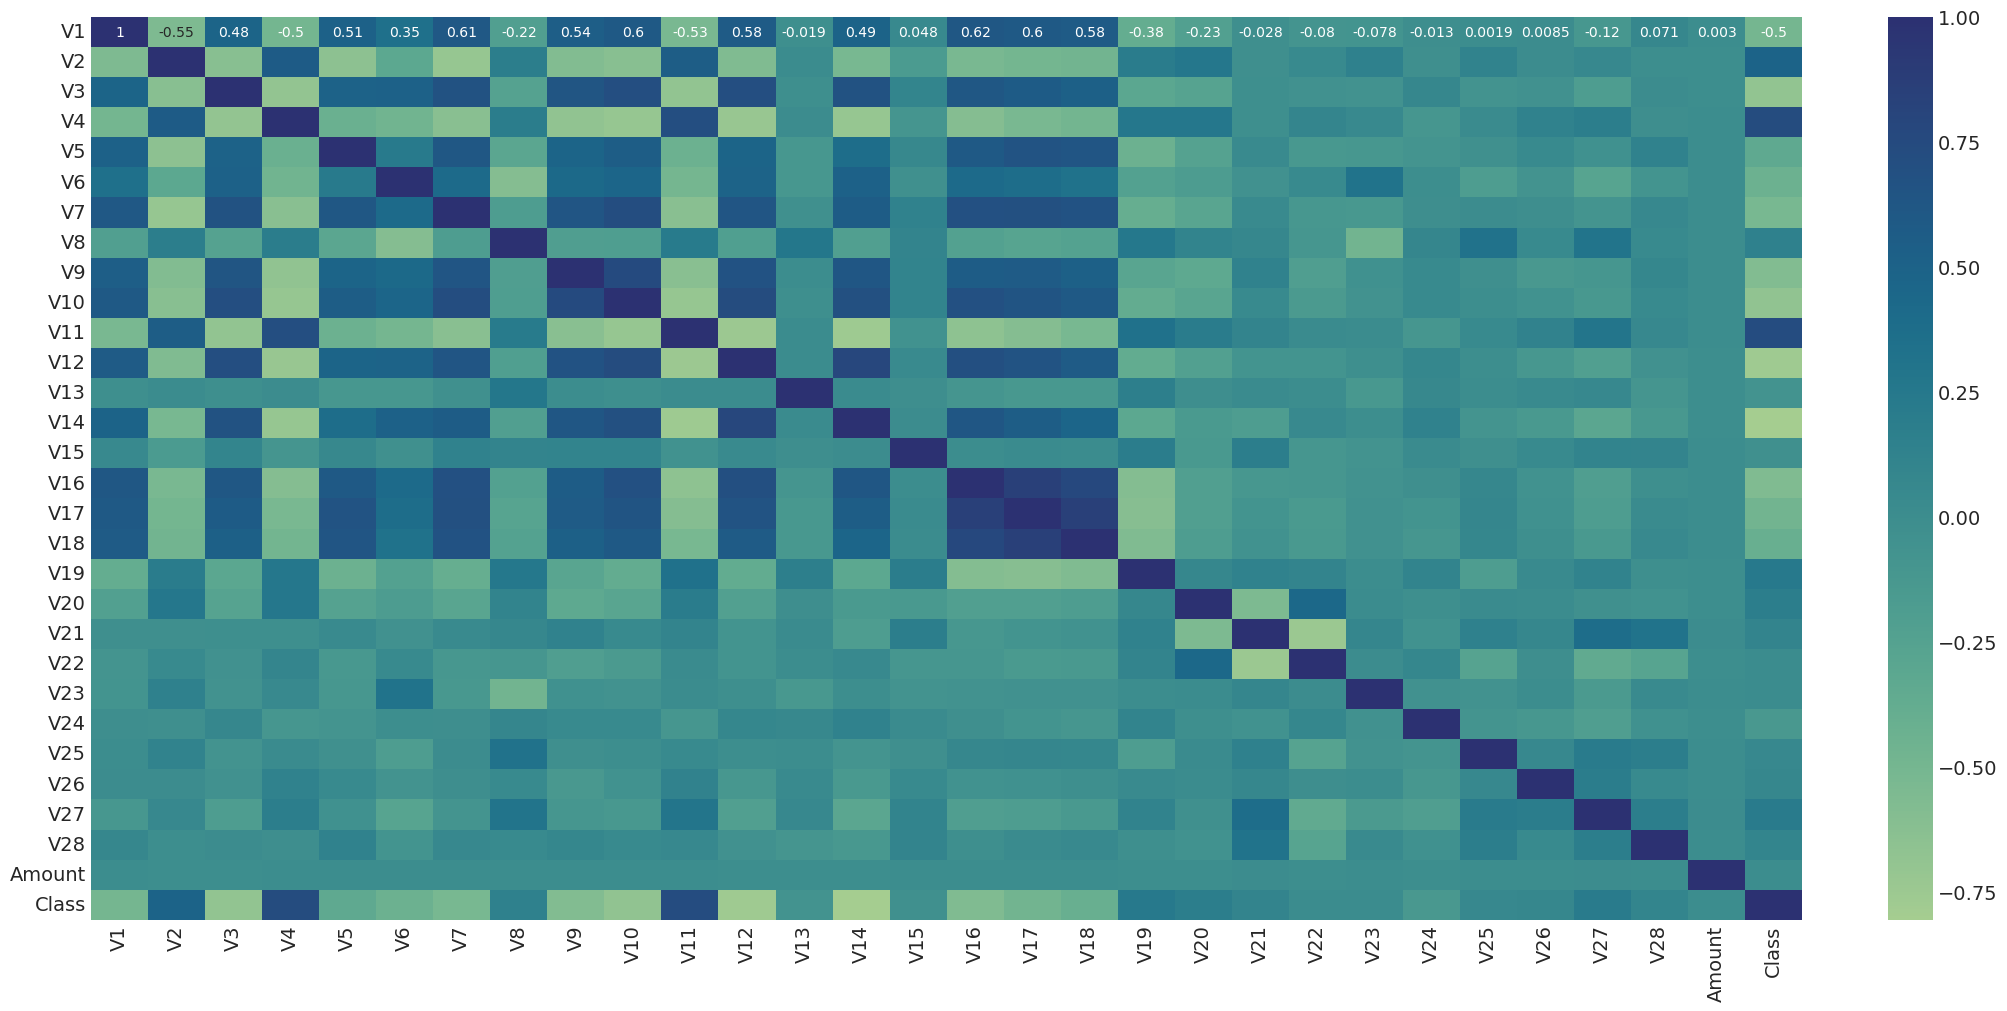

In [45]:
corr_matrix = data.corr()
plt.figure(figsize=[20,10])
sns.heatmap(corr_matrix, cmap='crest', annot=True)
plt.show()

In [46]:
high_corr_var = [(m, n) for m in corr_matrix.columns for n in corr_matrix.columns if (m != n) and abs(corr_matrix[m][n]) > 0.75]
print(high_corr_var)

[('V11', 'V14'), ('V12', 'V14'), ('V12', 'Class'), ('V14', 'V11'), ('V14', 'V12'), ('V14', 'Class'), ('V16', 'V17'), ('V16', 'V18'), ('V17', 'V16'), ('V17', 'V18'), ('V18', 'V16'), ('V18', 'V17'), ('Class', 'V12'), ('Class', 'V14')]


Seems like we have quite a high number of variables that are correlated with one another, which could a problem in our model. Let's first remove them.

In [47]:
data = data.drop(columns=['V11', 'V12', 'V16', 'V18'])

Then let's try to do Random Forest and see what the feature importance is.

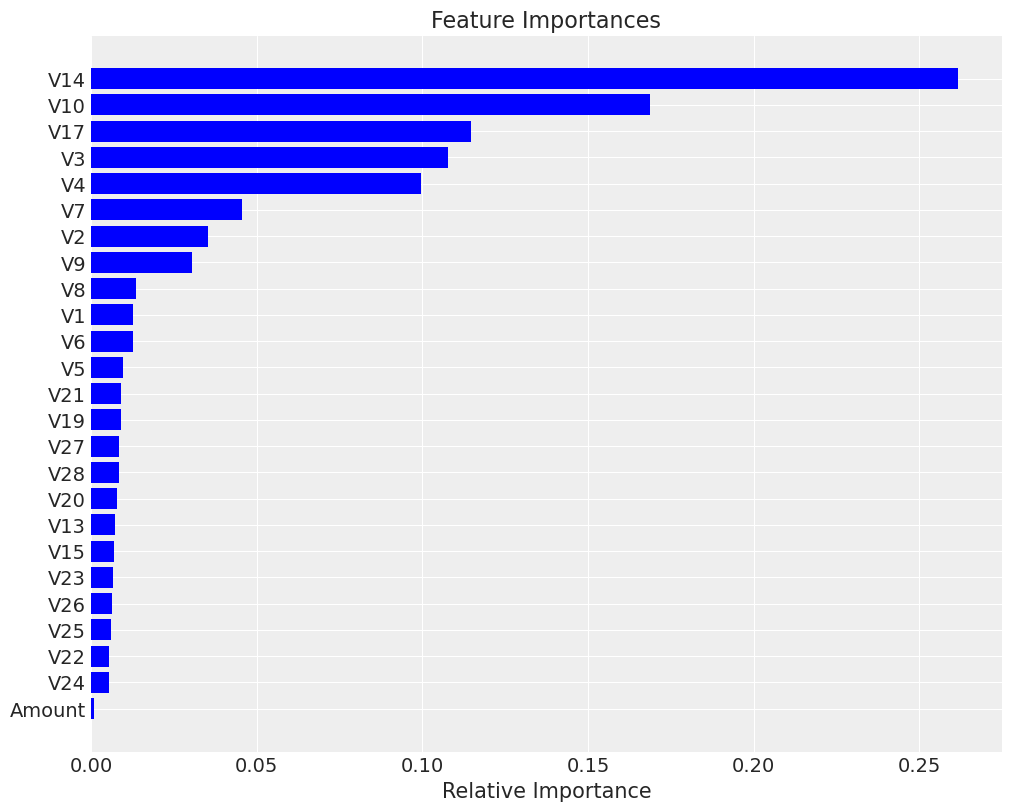

In [48]:
sampled_data = data.sample(n=30000, random_state=random_seed)
X = sampled_data.drop('Class', axis=1) 
y = sampled_data['Class']

rf = RandomForestClassifier(max_depth=50, 
                            n_jobs=-1)
rf.fit(X, y)

importances = rf.feature_importances_

features = X.columns
indices = np.argsort(importances)

plt.figure(figsize=(10, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Let's remove  less important features

In [49]:
data = data.drop(columns=[ 'V8', 'V1', 'V6', 'V5', 'V21', 'V19', 'V13', 'V20', 'V26', 'V15', 'V25', 'V23', 'V24', 'V28', 'V27', 'V22'])

### Modeling

In [50]:
X = data.drop('Class', axis=1)
y = data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=random_seed)

#### Naive Bayes Model

* **Use Sklearn Package** (No need to sample)

In [51]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9322


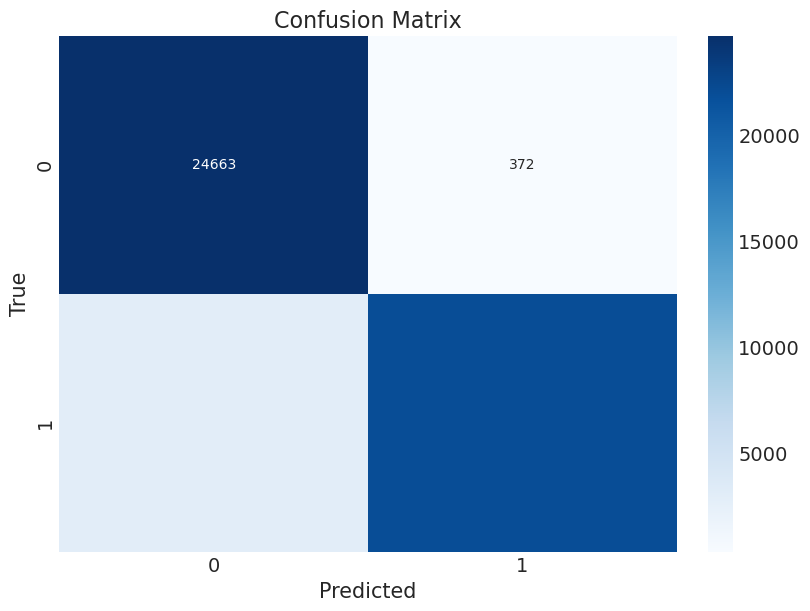

In [52]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

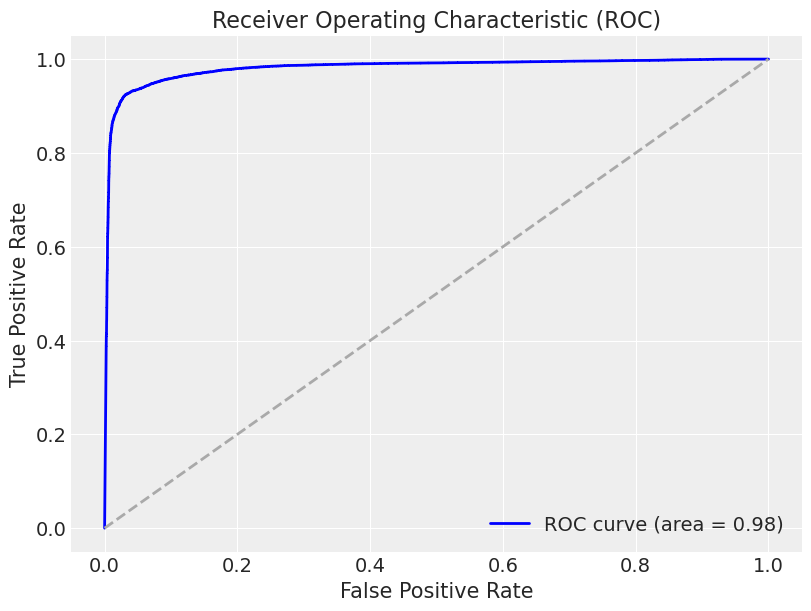

In [53]:
y_prob = gnb.predict_proba(X_test)[:, 1]


fpr, tpr, thresholds = roc_curve(y_test, y_prob)

auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkgrey', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [54]:
data.columns

Index(['V2', 'V3', 'V4', 'V7', 'V9', 'V10', 'V14', 'V17', 'Amount', 'Class'], dtype='object')

#### Logistic Regression

In [ ]:
#### Logistic Regression

#### Bayesian Model Averaging

In [ ]:
# Example Code

waic1 = pm.waic(trace1, model1)
waic2 = pm.waic(trace2, model2)


model_dict = {'Model1': (model1, trace1), 'Model2': (model2, trace2)}
comp = pm.compare(model_dict)

weights = pm.compare_weights(comp)

ppc = pm.sample_posterior_predictive_w(traces=[trace1, trace2],
                                       models=[model1, model2],
                                       weights=weights,
                                       samples=1000)
